## Imports

In [1]:
import torch
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt # try plotly express
from keras.datasets import cifar10  #
from keras.models import Sequential  # Model type to be used
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.applications.resnet import ResNet50
from resnet import ResNet34
import keras.utils as np_utils
import gc
import os

In [2]:
print(tf.config.list_physical_devices('GPU'))
torch.cuda.is_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [3]:
def save_to_file(path: str, obj):
	path_components = path.split('/')

	built_path = ''
	for component in path_components[:-1]:
		built_path += component + '/'
		if not os.path.exists(built_path):
			os.mkdir(built_path)

	with open(path, 'wb') as file:
		pickle.dump(obj, file)
		file.close()

In [4]:
NUM_DATASIZES = 10
NUM_MODELS = 5

datasizes = np.linspace(5000, 3000, NUM_DATASIZES).astype('int')
# Datasize 15: [5000, 4857, 4714, 4571, 4428, 4285, 4142, 4000, 3857, 3714, 3571, 3428, 3285, 3142, 3000]
# Datasize 10: [5000, 4777, 4555, 4333, 4111, 3888, 3666, 3444, 3222, 3000]
# Datasize 8: [5000, 4714, 4428, 4142, 3857, 3571, 3285, 3000])

BASE_PATH = 'cached/accuracies'
TEST_NAME = 'big_resnet_jacobian'
PROGRESS_DIR_NAME = 'prog'

RAND_PATH = f'./{BASE_PATH}/{TEST_NAME}/rand_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RAND_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/rand'
RAND_2_PATH = f'./{BASE_PATH}/{TEST_NAME}/rand_2_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
HIGH_PATH = f'./{BASE_PATH}/{TEST_NAME}/high_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
HIGH_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/high'
LOW_PATH = f'./{BASE_PATH}/{TEST_NAME}/low_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
LOW_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/low'
RATIO_LOW_PATH = f'./{BASE_PATH}/{TEST_NAME}/ratio_low_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RATIO_HIGH_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/ratio_high'
RATIO_HIGH_PATH = f'./{BASE_PATH}/{TEST_NAME}/ratio_high_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RATIO_LOW_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/ratio_low'
JACOBIAN_REDUCTION_PATH = f'./{BASE_PATH}/{TEST_NAME}/jacobian_{NUM_DATASIZES}ds_{NUM_MODELS}m'
JACOBIAN_REDUCTION_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/jacobian'

OLD_AVERAGE_PATH = './cached/output_curv/cifar_output_curv_AVG'
NEW_AVERAGE_PATH = './cached/output_curv/cifar_output_curv_AVG_15'

OUTPUT_CURV_PATH = './cached/output_curv/cifar_output_curv_RandomReduc.pth'
INPUT_CURV_PATH = 'cached/cifar_input_curv'
JACOBIAN_PATH = './cached/cifar_jacobians_v2'

### import pre-computed curvatures

In [5]:
# DON'T USE AVERAGE, JUST PICK ONE CURV
with open(OUTPUT_CURV_PATH, 'rb') as file:
  output_curvatures = pickle.load(file).squeeze()

with open(INPUT_CURV_PATH, 'rb') as file:
  input_curvatures = pickle.load(file).squeeze()

with open(JACOBIAN_PATH, 'rb') as file:
  jacobian_list = pickle.load(file).squeeze()

del file

## Define functions

In [6]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [7]:
def jacobian(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
	_input = torch.from_numpy(input)
	_target = torch.from_numpy(target)
	with tf.GradientTape() as tape:
		tape.watch(_input)
		out = model(_input)
		loss = lossfunc(out, _target)
		return np.array(tape.jacobian(loss, _input))

In [8]:
# if this network is robust, the curvature technique works better
# there are other curvature metrics, reducing by curvature should work theoretically
# 1st 2 wks: check other dataset reduction techniques (state o.t. art if possible). Implement and use as baseline
# 2nd 2 wks: experiment with new network/dataset, gather results.
# 3rd 2 wks: write thesis

# USE MORE COMPLEX MODEL
def create_cifar_model():
  return torch.nn.DataParallel(ResNet34().to('cuda'))
  return ResNet50(weights=None, input_shape=cifar_X_train.shape[1:], pooling='max', classes=10, classifier_activation='softmax')
  return Sequential([
    Conv2D(32, 3, padding='same', input_shape=cifar_X_train.shape[1:], activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ])

In [9]:
## From Bahadir ##
import torch.utils.data
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

def torchify_array(arr: np.ndarray | torch.Tensor | tf.Tensor, reshape=True, convert_type=False) -> torch.Tensor:
	out = arr
	if convert_type:
		out = torch.from_numpy(arr)
	out = out.type(torch.float)
	# add batch_dim if necessary
	if len(out.shape) == 3 or len(out.shape) == 1:
		out = torch.unsqueeze(out, 0)
	if reshape:
		out = out.reshape((out.shape[0], 3, 32, 32))
	return out.to('cuda')

transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
def train(network, epoch, batch_size=128, trainset='cifar10', testset='cifar10'):
	if trainset == 'cifar10':
		trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
	if testset == 'cifar10':
		testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

	dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
	testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
	criterion = nn.CrossEntropyLoss()
	optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
	scheduler1  = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.0001, end_factor=1.0, total_iters=2500)
	scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)
	scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2500])

	print('\nEpoch: %d' % epoch)
	network.train()
	train_loss = 0
	train_correct = 0
	train_total = 0
	no_of_training_steps = 0
	for inputs, targets in dataloader:
		inputs, targets =  torchify_array(inputs), torchify_array(targets, reshape=False)#inputs.to('cuda'), targets.to('cuda')#
		optimizer.zero_grad()
		outputs = network(inputs)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		_, predicted = outputs.max(1)
		_, actual = targets.max(1) # only if data is custom size
		train_total += targets.size(0)
		train_correct += predicted.eq(actual).sum().item()
		no_of_training_steps = no_of_training_steps + 1

		scheduler.step()
	print('train',100.*train_correct/train_total, train_correct, train_total, no_of_training_steps)

	network.eval()
	test_loss = 0
	test_correct = 0
	test_total = 0
	with torch.no_grad():
		for inputs, targets in testloader:
			inputs, targets = torchify_array(inputs), torchify_array(targets, reshape=False)#inputs.to('cuda'), targets.to('cuda')# 
			outputs = network(inputs)
			loss = criterion(outputs, targets)

			test_loss += loss.item()
			_, predicted = outputs.max(1)
			_, actual = targets.max(1) # only if data is custom size
			test_total += targets.size(0)
			test_correct += predicted.eq(actual).sum().item()

	final_acc = 100. * train_correct / train_total
	final_val_acc = 100. * test_correct / test_total
	
	return final_val_acc, final_acc

In [45]:
LR=4e-4
BATCH_SIZE=256
EPOCHS=1

def get_jacobians(lib='tf'):
	b_size = 1
	model = create_cifar_model()
	checkpoint = torch.load('./ckpt_100ep 1.pth')
	model.load_state_dict(checkpoint['net'])
	# model.eval()

	# if lib == 'tf':
	# 	model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=LR))
	# 	model.fit(cifar_X_train, cifar_Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
	# elif lib == 'torch':
	# 	for epoch in range(EPOCHS):
	# 		train(model, epoch)
	# else:
	# 	raise ValueError(f'unsupported library type: {lib}. Should be tf or torch')

	
	jacobian_list = []
	with tf.device('/gpu:0'):
		for i in range((cifar_X_train.shape[0] // b_size)):
			try:
				print(f'batch {i + 1} of {50000 // b_size}')
				x = cifar_X_train[b_size * i: b_size * (i + 1)]# (1, 32, 32, 3)
				if lib == 'tf':
					y = cifar_Y_train[b_size * i: b_size * (i + 1)]
					jac = jacobian(model, x, y)
					del y
				else:
					x = torchify_array(x, convert_type=True) # [1, 3, 32, 32]
					jac = torch.autograd.functional.jacobian(model, x).cpu() # [1, 10, 1, 3, 32, 32]
				del x
				jac = jac.squeeze() # remove weird batch stuff [10, 3, 32, 32]
				norm = tf.norm(jac, axis=(2, 3)) # [10, 3]
				norm = tf.norm(norm) # scalar
				jacobian_list.append(norm)
				del jac
			except Exception as e:
				print('ERROR CAUGHT, RETURNING PROGRESS:', e)
				return np.array(jacobian_list) # don't lose progress in the event of any error
	return np.array(jacobian_list)

In [46]:
jac = get_jacobians(lib='torch')

batch 1 of 50000
batch 2 of 50000
batch 3 of 50000
batch 4 of 50000
batch 5 of 50000
batch 6 of 50000
batch 7 of 50000
batch 8 of 50000
batch 9 of 50000
batch 10 of 50000
batch 11 of 50000
batch 12 of 50000
batch 13 of 50000
batch 14 of 50000
batch 15 of 50000
batch 16 of 50000
batch 17 of 50000
batch 18 of 50000
batch 19 of 50000
batch 20 of 50000
batch 21 of 50000
batch 22 of 50000
batch 23 of 50000
batch 24 of 50000
batch 25 of 50000
batch 26 of 50000
batch 27 of 50000
batch 28 of 50000
batch 29 of 50000
batch 30 of 50000
batch 31 of 50000
batch 32 of 50000
batch 33 of 50000
batch 34 of 50000
batch 35 of 50000
batch 36 of 50000
batch 37 of 50000
batch 38 of 50000
batch 39 of 50000
batch 40 of 50000
batch 41 of 50000
batch 42 of 50000
batch 43 of 50000
batch 44 of 50000
batch 45 of 50000
batch 46 of 50000
batch 47 of 50000
batch 48 of 50000
batch 49 of 50000
batch 50 of 50000
batch 51 of 50000
batch 52 of 50000
batch 53 of 50000
batch 54 of 50000
batch 55 of 50000
batch 56 of 50000
b

In [47]:
save_to_file('./cached/cifar_ckpt100_jacobians', jac)

In [37]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str, curvature_set='output'):
  _input_curvatures = input_curvatures
  _output_curvatures = output_curvatures
  _train_y = cifar_train_y[:, 0]

  _curvature_set = _input_curvatures if curvature_set == 'input' else _output_curvatures

  #### TEST ####
  if order_method == 'random':
    keep_indices = np.random.choice(X.shape[0], data_size * 10, replace=False)
    return X[keep_indices], Y[keep_indices]
  #### TEST ####
  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    #if order_method == 'random':
      # shouldn't we pick these truly randomly? not evenly based on class.
      # also, I think replace should be false to prevent repeat selections. it is supposed to be a subset
      # keep_indices = np.random.choice(X[class_indices].shape[0], data_size, replace=True) 
    if order_method == 'jacobian':
      # M * J^2 term =~ Hessian
      print(_curvature_set[y_class].shape, jacobian_list[class_indices].shape)
      twice_weighted_curvatures = _curvature_set[y_class] * jacobian_list[class_indices]
      keep_indices = np.argsort(twice_weighted_curvatures)[-data_size:]
    elif order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class])[-data_size:]
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class].shape[0] // 2

      keep_indices = np.argsort(_curvature_set[y_class])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    elif order_method == 'ratio_low_to_high':
      ratios = _output_curvatures[y_class] / _input_curvatures[y_class]
      keep_indices = np.argsort(ratios)[:data_size]
    elif order_method == 'ratio_high_to_low':
      ratios = _output_curvatures[y_class] / _input_curvatures[y_class]
      keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")

    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]
    del keep_indices

    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

In [12]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='output', num_models=5, shuffle_seed=None, progress_dir=None, overwrite=False):
  LR=4e-4
  BATCH_SIZE=256
  EPOCHS=100
  valacclist = []
  acclist = []

  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method, curvature_set)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for i in range(num_models):
      prog_path = f'{progress_dir}/datasize_{data_size}_model_{i}'

      # attempt to retrieve pre-computed accuracies (resume progress)
      if not overwrite and progress_dir and os.path.exists(prog_path):
        with open(prog_path, 'rb') as file:
          valacc, acc = pickle.load(file)
          file.close()
        valacclist[-1].append(valacc)
        acclist[-1].append(acc)
        print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
        continue

      # train model and record training/validation accuracy
      nt = create_cifar_model()
      # nt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=LR), metrics=['categorical_accuracy'])
      # history = nt.fit(Reduced_X_train, Reduced_Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test), verbose=0, batch_size=BATCH_SIZE)
      # del nt
      # acc = history.history['categorical_accuracy'][-1]
      # valacc = history.history['val_categorical_accuracy'][-1]
      # print(f"  MODEL {i + 1}: train acc = {acc:.5f} val acc = {valacc:.5f}")
      for epoch in range(EPOCHS):
        trainset = torch.utils.data.TensorDataset(torch.from_numpy(Reduced_X_train), torch.from_numpy(Reduced_Y_train))
        testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))
        valacc, acc = train(nt, epoch, trainset=trainset, testset=testset)
      valacclist[-1].append(valacc)
      acclist[-1].append(acc)

      # save progress to path if path is specified
      if progress_dir:
        save_to_file(prog_path, [valacc, acc])

      # clean up, important for conserving VRAM
      #del history
      gc.collect()

    del Reduced_X_train, Reduced_Y_train
  return valacclist, acclist

In [46]:
def plot_accuracies(accuracies: list[float], names: list[str]=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(np.linspace(100, 100 * datasizes[-1] / datasizes[0], datasizes.shape[0]).round().astype('int'), np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xlabel('Percentage of Dataset Used in Training (%)')
  plt.ylabel(f'Average Model Accuracy (n={NUM_MODELS})')
  plt.grid()
  plt.gca().invert_xaxis()
  plt.show()

### load data

In [12]:
(cifar_X_train, cifar_train_y), (cifar_X_test, cifar_test_y) = cifar10.load_data()

cifar_X_train = cifar_X_train / 255
cifar_X_test = cifar_X_test/ 255

cifar_Y_train = np_utils.to_categorical(cifar_train_y, 10)
cifar_Y_test = np_utils.to_categorical(cifar_test_y, 10)

### fine grain analysis on best performers

In [32]:
rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random', num_models=NUM_MODELS, progress_dir=RAND_PROG_PATH)
with open(RAND_PATH, 'wb') as file:
  pickle.dump(rand, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/rand/datasize_5000_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/rand/datasize_5000_model_1", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/rand/datasize_5000_model_2", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/rand/datasize_5000_model_3", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/rand/datasize_5000_model_4", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
ReducedX.shape: (47770, 32, 32, 3)


In [13]:
high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=HIGH_PROG_PATH)
with open(HIGH_PATH, 'wb') as file:
  pickle.dump(high, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.97876 val acc = 0.66100
  MODEL 2: train acc = 0.96518 val acc = 0.66970
  MODEL 3: train acc = 0.98102 val acc = 0.66970
  MODEL 4: train acc = 0.96198 val acc = 0.65880
  MODEL 5: train acc = 0.97654 val acc = 0.64660
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.98386 val acc = 0.64390
  MODEL 2: train acc = 0.98237 val acc = 0.65850
  MODEL 3: train acc = 0.97907 val acc = 0.63020
  MODEL 4: train acc = 0.96910 val acc = 0.65660
  MODEL 5: train acc = 0.67505 val acc = 0.59490
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97337 val acc = 0.66070
  MODEL 2: train acc = 0.98178 val acc = 0.61220
  MODEL 3: train acc = 0.96002 val acc = 0.61960
  MODEL 4: train acc = 0.98055 val acc = 0.64350
  MODEL 5: train acc = 0.97895 val acc = 0.62780
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.98048 val acc = 0.62370
  MODEL 2: train acc = 0.98013 val acc = 0.65270
  MODEL 3: train acc = 0.97

In [14]:
ratio_low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=RATIO_LOW_PROG_PATH)
with open(RATIO_LOW_PATH, 'wb') as file:
  pickle.dump(ratio_low, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.98058 val acc = 0.65980
  MODEL 2: train acc = 0.98064 val acc = 0.65000
  MODEL 3: train acc = 0.98092 val acc = 0.62930
  MODEL 4: train acc = 0.97962 val acc = 0.62850
  MODEL 5: train acc = 0.97736 val acc = 0.65910
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.97949 val acc = 0.64510
  MODEL 2: train acc = 0.96839 val acc = 0.65670
  MODEL 3: train acc = 0.97955 val acc = 0.63440
  MODEL 4: train acc = 0.78893 val acc = 0.53700
  MODEL 5: train acc = 0.88750 val acc = 0.63390
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97895 val acc = 0.60520
  MODEL 2: train acc = 0.97859 val acc = 0.64420
  MODEL 3: train acc = 0.88738 val acc = 0.54530
  MODEL 4: train acc = 0.98735 val acc = 0.67630
  MODEL 5: train acc = 0.91359 val acc = 0.66400
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97962 val acc = 0.61830
  MODEL 2: train acc = 0.97738 val acc = 0.64590
  MODEL 3: train acc = 0.98

In [15]:
ratio_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=RATIO_HIGH_PROG_PATH)
with open(RATIO_HIGH_PATH, 'wb') as file:
  pickle.dump(ratio_high, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.87134 val acc = 0.61730
  MODEL 2: train acc = 0.98196 val acc = 0.66750
  MODEL 3: train acc = 0.97436 val acc = 0.65790
  MODEL 4: train acc = 0.97932 val acc = 0.61790
  MODEL 5: train acc = 0.97902 val acc = 0.65420
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.97218 val acc = 0.65590
  MODEL 2: train acc = 0.95968 val acc = 0.60750
  MODEL 3: train acc = 0.98204 val acc = 0.66340
  MODEL 4: train acc = 0.96343 val acc = 0.66320
  MODEL 5: train acc = 0.97867 val acc = 0.65450
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.98143 val acc = 0.62930
  MODEL 2: train acc = 0.97993 val acc = 0.64360
  MODEL 3: train acc = 0.97783 val acc = 0.61210
  MODEL 4: train acc = 0.98119 val acc = 0.65690
  MODEL 5: train acc = 0.98077 val acc = 0.64230
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97911 val acc = 0.59890
  MODEL 2: train acc = 0.97856 val acc = 0.65040
  MODEL 3: train acc = 0.97

In [16]:
low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='low_to_high', curvature_set='output', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=LOW_PROG_PATH)
with open(LOW_PATH, 'wb') as file:
  pickle.dump(low, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.97654 val acc = 0.63350
  MODEL 2: train acc = 0.97670 val acc = 0.64640
  MODEL 3: train acc = 0.97036 val acc = 0.65760
  MODEL 4: train acc = 0.97906 val acc = 0.65950
  MODEL 5: train acc = 0.98002 val acc = 0.65240
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.98039 val acc = 0.67190
  MODEL 2: train acc = 0.97944 val acc = 0.62990
  MODEL 3: train acc = 0.88327 val acc = 0.65940
  MODEL 4: train acc = 0.96747 val acc = 0.64980
  MODEL 5: train acc = 0.98026 val acc = 0.62590
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97873 val acc = 0.64900
  MODEL 2: train acc = 0.98586 val acc = 0.64720
  MODEL 3: train acc = 0.97811 val acc = 0.62570
  MODEL 4: train acc = 0.91570 val acc = 0.64150
  MODEL 5: train acc = 0.97892 val acc = 0.64230
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97581 val acc = 0.60810
  MODEL 2: train acc = 0.97985 val acc = 0.61990
  MODEL 3: train acc = 0.98

In [15]:
jacobian_method_results, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='jacobian', num_models=NUM_MODELS, progress_dir=JACOBIAN_REDUCTION_PROG_PATH)
with open(JACOBIAN_REDUCTION_PATH, 'wb') as file:
  pickle.dump(jacobian_method_results, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/jacobian/datasize_5000_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/jacobian/datasize_5000_model_1", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/jacobian/datasize_5000_model_2", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/jacobian/datasize_5000_model_3", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/big_resnet_jacobian/prog/jacobian/datasize_5000_model_4", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
ReducedX.shape:

In [17]:
with open(RAND_PATH, 'rb') as file:
  rand = pickle.load(file)
  file.close()
with open(JACOBIAN_REDUCTION_PATH, 'rb') as file:
  jac = pickle.load(file)
  file.close()
'''
with open(RATIO_HIGH_PATH, 'rb') as file:
  ratio_high = pickle.load(file)
  file.close()
with open(RATIO_LOW_PATH, 'rb') as file:
  ratio_low = pickle.load(file)
  file.close()
'''

"\nwith open(RATIO_HIGH_PATH, 'rb') as file:\n  ratio_high = pickle.load(file)\n  file.close()\nwith open(RATIO_LOW_PATH, 'rb') as file:\n  ratio_low = pickle.load(file)\n  file.close()\n"

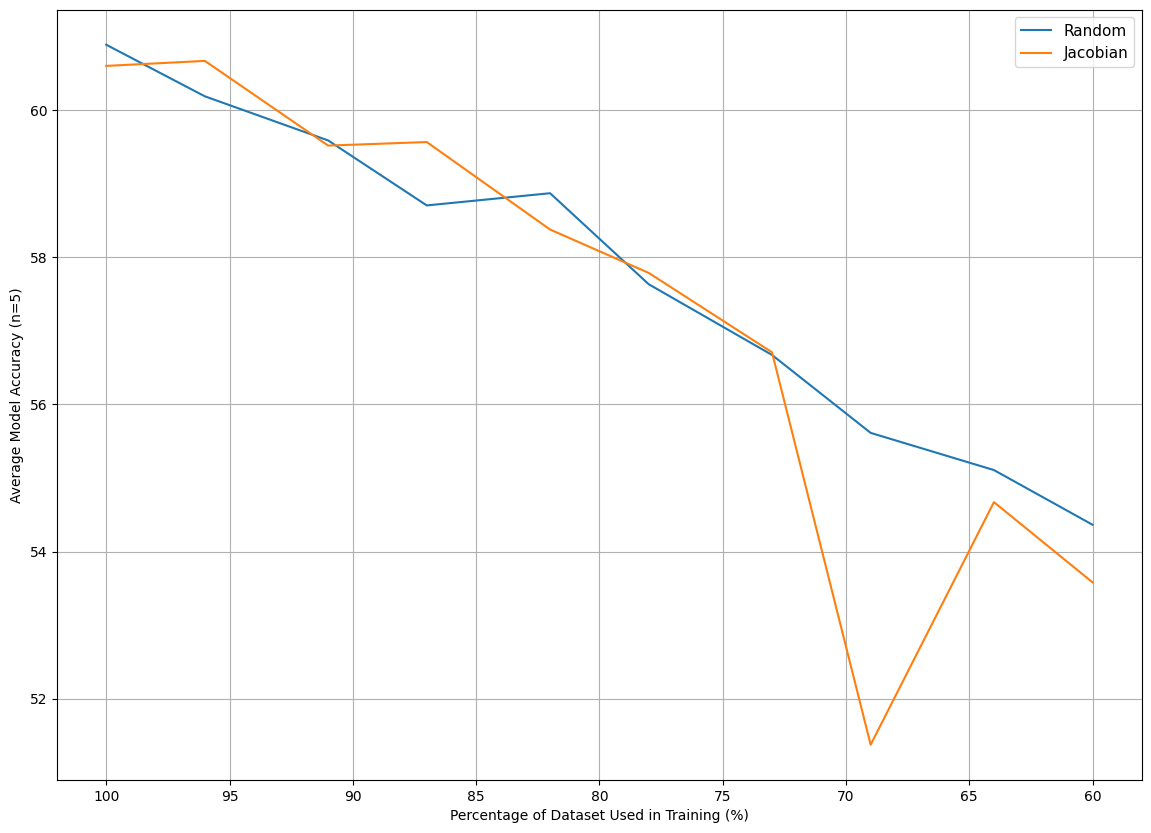

In [48]:
namelist = ['Random', 'Jacobian']#'NEW Random', 'Highest Curvatures', 'Low Output/Input Ratio', 'High Output/Input Ratio']
plot_accuracies([rand, jac], namelist)#rand_2, high, ratio_low, ratio_high], namelist)

### close up on ratio tests

In [ ]:
namelist = ['Random selection', 'Low Output/Input Ratio', 'High Output/Input Ratio']
datasizes = np.logspace(3.699, 2.599, 20).astype('int')

rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random', num_models=15)
ratio_low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=15)
ratio_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=15)

plot_accuracies([rand, ratio_low, ratio_high], namelist)

In [ ]:
plot_accuracies([rand, ratio_low, ratio_high], namelist)

In [ ]:
# these take a while to train, so I'm breaking them into their own cells to avoid retraining all of them if changes need to be mande to just one
rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random')

In [ ]:
hess, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='hessian')

In [ ]:
keep_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='high_to_low', curvature_set='output')

In [ ]:
plot_accuracies([rand, hess, keep_high], ['rand', 'hess', 'keep_high'])